# AlgoSB 2021

Practical afternoon session Monday, 8th of November. Time-series analysis, covering:

  - Principle component analysis
  - Time-lagged independent analysis
  - Clustering
  - MSM estimation

In [1]:
from dataclasses import dataclass
import sys
import warnings

import cnnclustering
from cnnclustering import cluster
from IPython.core.display import display, HTML
import  matplotlib as mpl
import matplotlib.pyplot as plt
import nglview
import numpy as np
import pyemma
import scipy
from scipy.stats import multivariate_normal
import sklearn
import sklearn.decomposition
import sklearn.cluster

Optional dependency module not found:  No module named 'networkx'
Optional dependency module not found:  No module named 'networkx'


In [2]:
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
# Version information
print("Python: ", *sys.version.split("\n"))

print("Packages:")
for package in [mpl, np, scipy, sklearn, pyemma, nglview, cnnclustering]:
    print(f"    {package.__name__}: {package.__version__}")

Python:  3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:57:06)  [GCC 9.4.0]
Packages:
    matplotlib: 3.2.2
    numpy: 1.21.3
    scipy: 1.7.1
    sklearn: 1.0
    pyemma: 2.5.9
    nglview: 3.0.3
    cnnclustering: 0.5.0


In [4]:
# Matplotlib configuration
mpl.rc_file(
    "../matplotlibrc",
    use_default_template=False
)

In [5]:
warnings.simplefilter("ignore")

## Motivation

In [6]:
%%HTML
<video width="90%" src="motivation.mp4" controls></video>

## Outline and organisation

We will demonstrate a few types of analyses that can be used in Markov-model estimation workflows on Molecular Dynamics data. Instead of "real world" MD trajectories, we will use artificial time-series that we produce as follows:

  - We define a **transition-probability matrix** for a number of (conformational) states. An element $ij$ in this matrix denotes the observation probability for a (conformational) transition from state $i$ to state $j$ within a time-step.
  - Starting from this matrix, we generate a possible time-series in state space, i.e. a **discrete trajectory**, which reflects the given transition probabilities.
  - Next, we define our states in terms of underlying **probability distributions** in a **feature space** (e.g. multivariate gaussians).
  - For each time-step in the discrete time-series, we draw a (conformational) sample from the distribution of the  corresponding state to generate a **continuous trajectory**
  - The continuous trajectory (conformational snapshots in the feature space) are subjected to different analyses.

<div class="alert alert-info">

**Note:** In a "real" analysis we would proceed basically the other way round. Starting from a trajectory trough a continuous feature space obtained by a MD simulation, we want to produce a discrete trajectory (e.g. trough clustering) to finally estimate a transition probability matrix that describes our system.
</div>

To organise the "systems" we investigate in this exercise, let's use a simple wrapping object to collect everything a system is made of:

In [7]:
@dataclass
class System:
    desc: str
    transition_p_matrix: np.ndarray = None
    dtraj: np.ndarray = None
    state_distr_map: dict = None
    traj: np.ndarray = None
    pca=None
    tica=None
    clustering_commonnn=None
    clustering_voronoi=None

## Data set generation

In [8]:
system_intro = System("Introductory example")
system = system_intro

### Transition probability matrix and time-series over states

$$
P(\tau) =
\begin{pmatrix}
    p_{00} & ... & p_{02}\\
    \vdots & \ddots & \vdots\\
    p_{20} & ... & p_{22}\\
\end{pmatrix}
= \begin{pmatrix}
    0.98 & 0.00 & 0.02\\
    0.00 & 0.89 & 0.11\\
    0.02 & 0.11 & 0.87\\
\end{pmatrix}
$$

$p_{ij}$: Probability that the system is in state $j$ at time $t + \tau$ after being in state $i$ at time $t$.

In [9]:
# Arbitrary transition probabilities for three states
system.transition_p_matrix = np.array([
    [0.98, 0.00, 0.02],
    [0.00, 0.89, 0.11],
    [0.02, 0.11, 0.87],
])

In [10]:
# Dummy MSM from transition probabilities
sampled_msm = pyemma.msm.SampledMSM(system.transition_p_matrix)
system.dtraj = sampled_msm.simulate(5000)

In [11]:
system.dtraj[:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

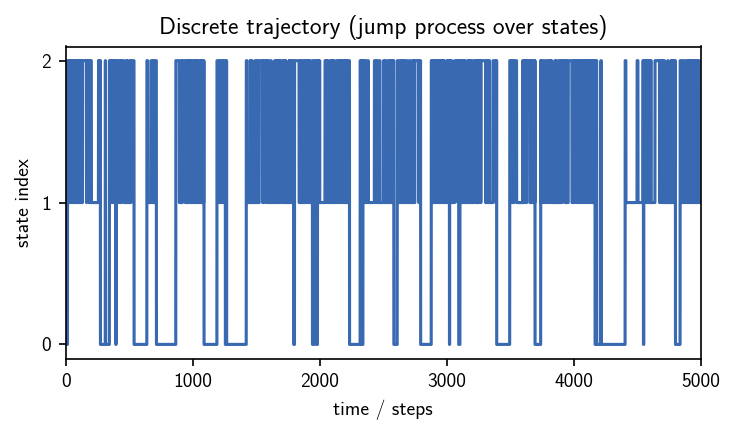

In [12]:
fig, ax = plt.subplots()
line, = ax.plot(system.dtraj)
ax.set(**{
    "title": "Discrete trajectory (jump process over states)",
    "xlabel": "time / steps",
    "ylabel": "state index",
    "xlim": (0, len(system.dtraj)),
    "yticks": np.unique(system.dtraj)
})
fig.tight_layout()

### Probability distributions for states in feature space

Let's assume we know for each state a corresponding probability distribution in a $k$-dimensional conformational space $\mathbb{R}^k$. For example, let's model each state by a multivariate Gaussian with center $\mu$ and covariance matrix $\Sigma$:

$$
f(x) = \frac{1}{\sqrt{(2\pi)^k \det \Sigma}} \exp\left(-\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu)\right)
$$

In [13]:
# Three states in 2D
state_centers = np.array([
    [-1, 1],
    [1, -1],
    [2, 2],
])
state_covs = np.array([
    [[0.1, 0.0],
     [0.0, 0.3]],
    [[0.4, 0.0],
     [0.0, 0.4]],    
    [[0.2, 0.0],
     [0.0, 0.2]],
])

In [14]:
def make_state_distributions(centers, covs):
    """Create a mapping of state IDs to gaussian distributions"""

    return {
        index: multivariate_normal(mean=center, cov=cov)
        for index, (center, cov) in enumerate(zip(centers, covs))
    }

In [15]:
system.state_distr_map = make_state_distributions(state_centers, state_covs)

In [16]:
# Draw a random point from a state distribution
system.state_distr_map[0].rvs()

array([-1.19308707,  0.33641308])

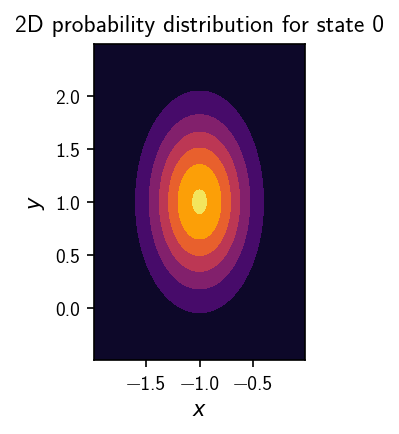

In [17]:
x, y = np.mgrid[-1.99:0:.01, -0.49:2.5:.01]
pos = np.dstack((x, y))

state_index = 0

fig, ax = plt.subplots()
ax.contourf(
    x, y, system.state_distr_map[state_index].pdf(pos),
    cmap=mpl.cm.inferno
)
ax.set(**{
    "aspect": "equal",
    "title": f"2D probability distribution for state {state_index}",
    "xlabel": "$x$",
    "ylabel": "$y$",
})
fig.tight_layout()

### Continuous trajectory through feature space

Now we can translate the discrete trajectory through state space into a (randomised) continuous trajectory in feature space.

In [18]:
def sample_trajectory_from_discrete(dtraj, mapping):
    """Map discrete state trajectory to random conformational samples"""
    return np.array([
        mapping[state].rvs()
        for state in dtraj
    ])

In [19]:
system.traj = sample_trajectory_from_discrete(
    system.dtraj,
    system.state_distr_map
)

In [20]:
def get_transition_points(dtraj):
    """Determine state transition points in discrete trajectory"""

    inter_state_transitions = []

    for i, state in enumerate(dtraj[1:]):
        last_state = dtraj[i]

        if state != dtraj[i]:
            inter_state_transitions.append(i)
            
    return inter_state_transitions

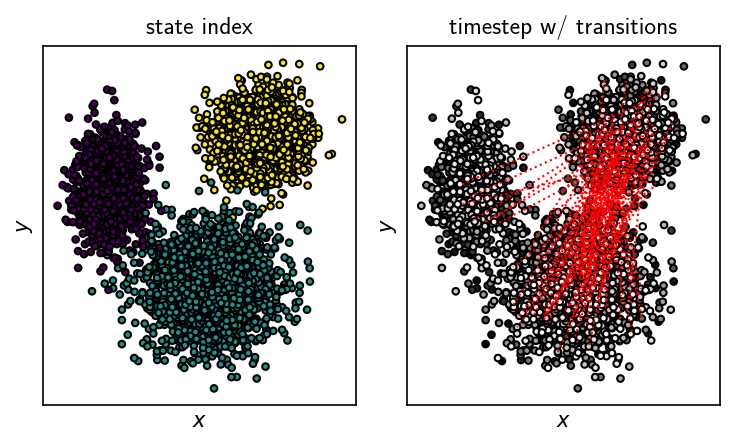

In [21]:
fig, (state_ax, time_ax) = plt.subplots(1, 2)
state_ax.scatter(
    *system.traj.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)
time_ax.scatter(
    *system.traj.T,
    c=np.arange(system.traj.shape[0]),
    s=10,
    edgecolors="k", linewidths=1,
    cmap=mpl.cm.gray
)

for i in get_transition_points(system.dtraj):
    if i % 5 != 0:
        continue
    start = system.traj[i]
    end = system.traj[i + 1]
    time_ax.plot(
        [start[0], end[0]], [start[1], end[1]],
        color="red", linestyle="dotted", linewidth=1,
    )

for ax in (state_ax, time_ax):
    ax.set(**{
        "aspect": "equal",
        "xticks": (),
        "yticks": (),
        "xlabel": "$x$",
        "ylabel": "$y$"
    })
    
state_ax.set_title("state index")
time_ax.set_title("timestep w/ transitions")

fig.tight_layout()

### Exercise

Use the described scheme to generate your own toy data set, starting from a self-defined transition probability matrix (e.g. four states in 3D).

In [22]:
system_a = System("Another example")
system = system_a

In [23]:
system.transition_p_matrix = np.array([
    [0.97, 0.01, 0.01, 0.01],
    [0.02, 0.89, 0.06, 0.03],
    [0.03, 0.07, 0.60, 0.30],
    [0.04, 0.05, 0.29, 0.62],
])

assert np.all(np.sum(system.transition_p_matrix, axis=1) == 1)

# Dummy MSM from transition probabilities
sampled_msm = pyemma.msm.SampledMSM(system.transition_p_matrix)
system.dtraj = sampled_msm.simulate(7500)

# Four states in 3D
state_centers = np.array([
    [ 2.5,  2.5,  2.5],
    [-2,  2,  2],
    [ 3.5, -2.5, -2],
    [ 0,  0,  0],
])
state_covs = np.array([
    [[0.2, 0.1, 0.1],
     [0.1, 0.2, 0.0],
     [0.1, 0.0, 0.2]],    
    [[0.1, 0.0, 0.0],
     [0.0, 0.3, 0.0],
     [0.0, 0.0, 0.2]],
    [[0.4, 0.0, 0.0],
     [0.0, 0.4, 0.0],
     [0.0, 0.0, 0.4]],    
    [[0.3, 0.0, 0.0],
     [0.0, 0.2, 0.1],
     [0.0, 0.1, 0.1]],
])

system.state_distr_map = make_state_distributions(state_centers, state_covs)

system.traj = sample_trajectory_from_discrete(
    system.dtraj,
    system.state_distr_map
)

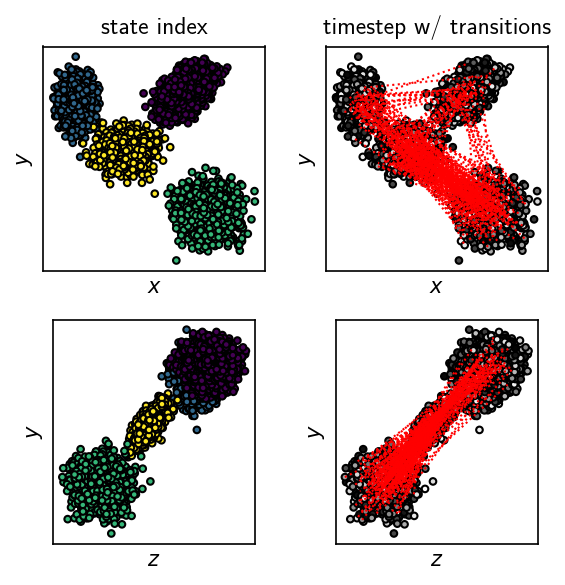

In [24]:
fig, Ax = plt.subplots(
    2, 2,
    figsize=(4, 4)
)
state_ax_a, time_ax_a, state_ax_b, time_ax_b = Ax.flatten()

order_a = np.argsort(system.traj[:, 2])[::-1]
state_ax_a.scatter(
    system.traj[:, 0][order_a],
    system.traj[:, 1][order_a],
    c=system.dtraj[order_a],
    s=10,
    edgecolors="k", linewidths=1,
    
)
order_b = np.argsort(system.traj[:, 0])
state_ax_b.scatter(
    system.traj[:, 2][order_b],
    system.traj[:, 1][order_b],
    c=system.dtraj[order_b],
    s=10,
    edgecolors="k", linewidths=1
)

time_ax_a.scatter(
    system.traj[:, 0][order_a],
    system.traj[:, 1][order_a],
    c=np.arange(system.traj.shape[0])[order_a],
    s=10,
    edgecolors="k", linewidths=1,
    cmap=mpl.cm.gray
)
time_ax_b.scatter(
    system.traj[:, 2][order_b],
    system.traj[:, 1][order_b],
    c=np.arange(system.traj.shape[0])[order_b],
    s=10,
    edgecolors="k", linewidths=1,
    cmap=mpl.cm.gray
)

for i in get_transition_points(system.dtraj):
    if i % 5 != 0:
        continue
    start = system.traj[i]
    end = system.traj[i + 1]
    time_ax_a.plot(
        [start[0], end[0]], [start[1], end[1]],
        color="red", linestyle="dotted", linewidth=1,
    )
    time_ax_b.plot(
        [start[2], end[2]], [start[1], end[1]],
        color="red", linestyle="dotted", linewidth=1,
    )

for ax in (state_ax_a, time_ax_a):
    ax.set(**{
        "aspect": "equal",
        "xticks": (),
        "yticks": (),
        "xlabel": "$x$",
        "ylabel": "$y$"
    })
    
for ax in (state_ax_b, time_ax_b):
    ax.set(**{
        "aspect": "equal",
        "xticks": (),
        "yticks": (),
        "xlabel": "$z$",
        "ylabel": "$y$"
    })
    
state_ax_a.set_title("state index")
time_ax_a.set_title("timestep w/ transitions")

fig.tight_layout()

## Principle component analysis

We want to use PCA to transform the input coordinates into a new set of *meaningful* coordinates. After PCA, the first obtained coordinate ($PC_1$) is aligned with the axis of maximum variance in the input space.

In [25]:
system = system_intro

In [26]:
# Do PCA
system.pca = sklearn.decomposition.PCA(n_components=2)
system.pca.fit(system.traj)

PCA(n_components=2)

In [27]:
# Obtained principle components (n_component, n_dim)
components = system.pca.components_
components

array([[ 0.47020553,  0.88255694],
       [-0.88255694,  0.47020553]])

In [28]:
# Project original trajectory into PC-space
projected_trajectory = system.pca.transform(system.traj)

In [29]:
# How much information is entailed in the PCs?
system.pca.explained_variance_ratio_

array([0.59864319, 0.40135681])

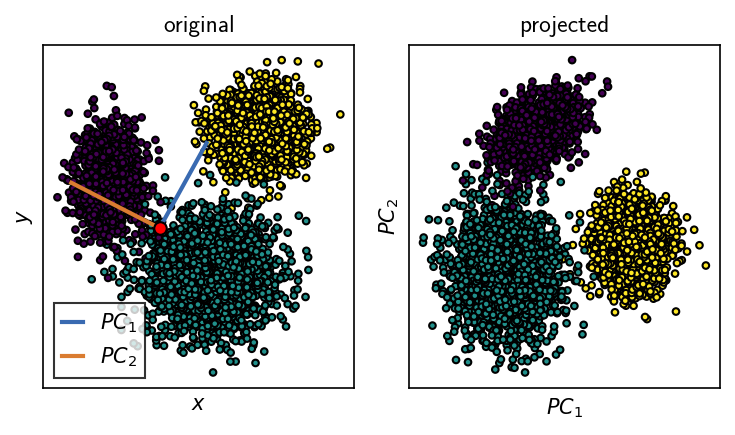

In [30]:
fig, (o_ax, p_ax) = plt.subplots(1, 2)
o_ax.scatter(
    *system.traj.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)

scale = 2  # Scale PC vectors by this factor
o_ax.plot([0, components[0, 0] * scale], [0, components[0, 1] * scale], linewidth=2)
o_ax.plot([0, components[1, 0] * scale], [0, components[1, 1] * scale], linewidth=2)
o_ax.plot([0], [0], markerfacecolor="red", marker="o", markeredgecolor="k")

p_ax.scatter(
    *projected_trajectory.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)
o_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$x$",
    "ylabel": "$y$",
    "title": "original"
})

p_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$PC_1$",
    "ylabel": "$PC_2$",
    "title": "projected"
})

o_ax.legend(
    ["$PC_1$", "$PC_2$"],
    handlelength=1,
    fancybox=False,
    edgecolor="k"
)

fig.tight_layout()

### Exercise

Use `sklearn.decomposition.PCA` to perform a principle component analysis on your own data set. Visualize the obtained components and the trajectory projected onto the first two of them. How much of the total variance in the data set is explained by the PCs? How many components would you keep?

In [31]:
system = system_a

In [32]:
# Do the full analysis (all components)
system.pca = sklearn.decomposition.PCA(n_components=3)
system.pca.fit(system.traj)

PCA(n_components=3)

In [33]:
system.pca.explained_variance_ratio_

array([0.60456669, 0.37355703, 0.02187628])

In [34]:
# Keep only the first two PCs
system.pca = sklearn.decomposition.PCA(n_components=2)
system.pca.fit(system.traj)

PCA(n_components=2)

In [35]:
components = system.pca.components_

In [36]:
projected_trajectory = system.pca.transform(system.traj)

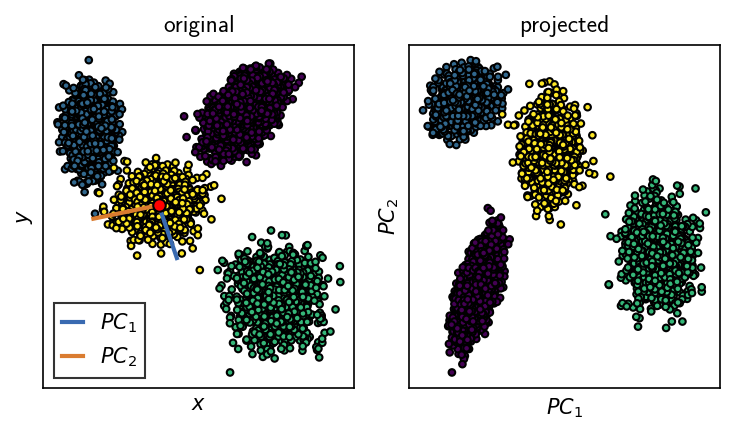

In [37]:
fig, (o_ax, p_ax) = plt.subplots(1, 2)

order_o = np.argsort(system.traj[:, 2])[::-1]
o_ax.scatter(
    system.traj[:, 0][order_o],
    system.traj[:, 1][order_o],
    c=system.dtraj[order_o],
    s=10,
    edgecolors="k", linewidths=1
)

scale = 2  # Scale PC vectors by this factor
o_ax.plot([0, components[0, 0] * scale], [0, components[0, 1] * scale], linewidth=2)
o_ax.plot([0, components[1, 0] * scale], [0, components[1, 1] * scale], linewidth=2)
o_ax.plot([0], [0], markerfacecolor="red", marker="o", markeredgecolor="k")


p_ax.scatter(
    *projected_trajectory.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)
o_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$x$",
    "ylabel": "$y$",
    "title": "original"
})

p_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$PC_1$",
    "ylabel": "$PC_2$",
    "title": "projected"
})

o_ax.legend(
    ["$PC_1$", "$PC_2$"],
    handlelength=1,
    fancybox=False,
    edgecolor="k"
)

fig.tight_layout()

## Correlation

In [38]:
system = system_intro

### Exercise

Use `numpy.corrcoef` to calculate the Pearson correlation coefficient between the two original coordinates and between the obtained principle components. What do  you observe?

In [39]:
corrcoeff = np.corrcoef(system.traj[:, 0], system.traj[:, 1])[0, 1]
corrcoeff_projected = np.corrcoef(projected_trajectory[:, 0], projected_trajectory[:, 1])[0, 1]
print(f"Correlation (original):  {corrcoeff}")
print(f"Correlation (projected): {corrcoeff_projected}")

Correlation (original):  0.1647416724405184
Correlation (projected): 6.948104727771085e-17


## Time-lagged independent component analysis

We want to use TICA as an alternative to PCA to transform the input coordinates into a new set of *meaningful* coordinates. After TICA, the first obtained coordinate ($tIC_1$) is aligned with the axis of slowest geometric change in the input space.

In [40]:
system = system_intro

In [41]:
# Do TICA
system.tica = pyemma.coordinates.tica(system.traj, var_cutoff=1)

In [42]:
# Obtained principle components (n_component, n_dim)
tica_components = system.tica.eigenvectors.T
tica_components

array([[ 0.50993704, -0.199255  ],
       [ 0.02317584,  0.07102167]])

In [43]:
# General info
system.tica.describe()

'[TICA, lag = 10; max. output dim. = 2]'

In [44]:
# Original data projected into TICA-space
projected_trajectory = np.concatenate(system.tica.get_output())

In [45]:
# How much information is entailed by the componentes (cummulatively)?
system.tica.cumvar

array([0.9733623, 1.       ])

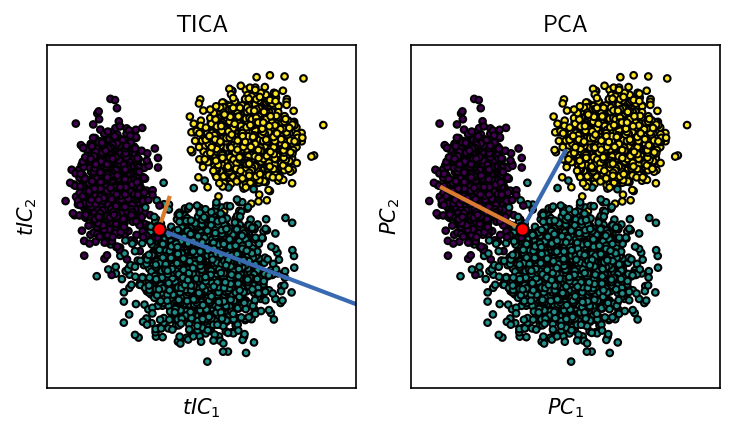

In [46]:
fig, (tica_ax, pca_ax) = plt.subplots(1, 2)
tica_ax.scatter(
    *system.traj.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)

scale = 10
tica_ax.plot([0, tica_components[0, 0] * scale], [0, tica_components[0, 1] * scale], linewidth=2)
tica_ax.plot([0, tica_components[1, 0] * scale], [0, tica_components[1, 1] * scale], linewidth=2)
tica_ax.plot([0], [0], markerfacecolor="red", marker="o", markeredgecolor="k")

pca_ax.scatter(
    *system.traj.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)

scale = 2
pca_ax.plot([0, system.pca.components_[0, 0] * scale], [0, system.pca.components_[0, 1] * scale], linewidth=2)
pca_ax.plot([0, system.pca.components_[1, 0] * scale], [0, system.pca.components_[1, 1] * scale], linewidth=2)
pca_ax.plot([0], [0], markerfacecolor="red", marker="o", markeredgecolor="k")

xmin, xmax = system.traj[:, 0].min(), system.traj[:, 0].max()
ymin, ymax = system.traj[:, 1].min(), system.traj[:, 1].max()

limit_factor = 1.2
tica_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$tIC_1$",
    "ylabel": "$tIC_2$",
    "title": "TICA",
    "xlim": (xmin * limit_factor, xmax * limit_factor),
    "ylim": (ymin * limit_factor, ymax * limit_factor),
})

pca_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$PC_1$",
    "ylabel": "$PC_2$",
    "title": "PCA",
    "xlim": (xmin * limit_factor, xmax * limit_factor),
    "ylim": (ymin * limit_factor, ymax * limit_factor),
})

fig.tight_layout()

### Exercise

Use `pyemma.coordinates.tica` to perform a time-lagged independent component analysis on your own data set. Compare the result to the PCA.

In [47]:
system = system_a

In [48]:
# Do the full analysis
system.tica = pyemma.coordinates.tica(system.traj, var_cutoff=1)

In [49]:
system.tica.cumvar

array([0.9744197 , 0.99934823, 1.        ])

In [50]:
# Keep only two components
system.tica = pyemma.coordinates.tica(system.traj, var_cutoff=0.999)

In [51]:
system.tica.describe()

'[TICA, lag = 10; max. output dim. = 2]'

In [52]:
components = system.tica.eigenvectors.T

In [53]:
projected_trajectory = np.concatenate(system.tica.get_output())

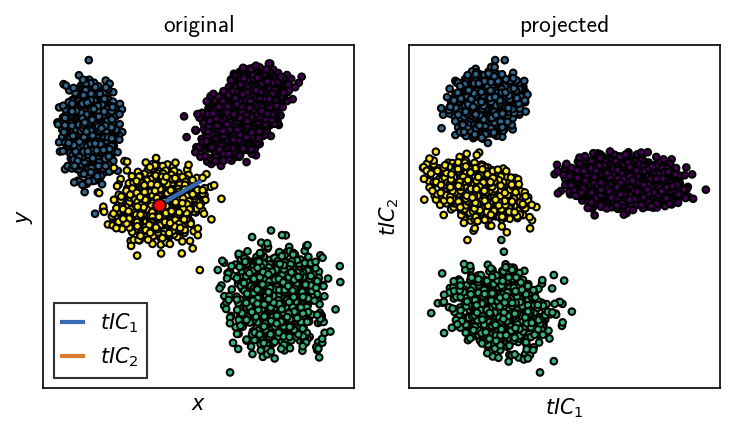

In [54]:
fig, (o_ax, p_ax) = plt.subplots(1, 2)

order_o = np.argsort(system.traj[:, 2])[::-1]
o_ax.scatter(
    system.traj[:, 0][order_o],
    system.traj[:, 1][order_o],
    c=system.dtraj[order_o],
    s=10,
    edgecolors="k", linewidths=1
)

scale = 6  # Scale PC vectors by this factor
o_ax.plot([0, components[0, 0] * scale], [0, components[0, 1] * scale], linewidth=2)
o_ax.plot([0, components[1, 0] * scale], [0, components[1, 1] * scale], linewidth=2)
o_ax.plot([0], [0], markerfacecolor="red", marker="o", markeredgecolor="k")


p_ax.scatter(
    *projected_trajectory.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)
o_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$x$",
    "ylabel": "$y$",
    "title": "original"
})

p_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$tIC_1$",
    "ylabel": "$tIC_2$",
    "title": "projected"
})

o_ax.legend(
    ["$tIC_1$", "$tIC_2$"],
    handlelength=1,
    fancybox=False,
    edgecolor="k"
)

fig.tight_layout()

## Clustering to generate discrete trajectories

We want to use density-based CommonNN clustering to assign each point in the data set to a (conformational) state. 

In [55]:
system = system_intro

In [56]:
# Choose the space
data = np.concatenate(system.tica.get_output())

In [57]:
# Prepare for clustering
system.clustering_commonnn = cluster.Clustering(data)

In [58]:
# Cluster with given radius and similarity cutoff
system.clustering_commonnn.fit(0.05, 70, member_cutoff=10)

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
5000      0.050     70        10        None      3         0.270     0.381     00:00:1.660
-----------------------------------------------------------------------------------------------



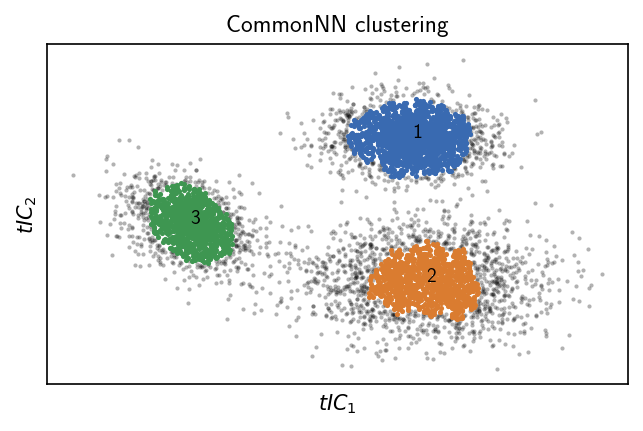

In [59]:
fig, ax = plt.subplots()
system.clustering_commonnn.evaluate(ax=ax)
_ = ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$tIC_1$",
    "ylabel": "$tIC_2$",
    "title": "CommonNN clustering"
})

Alternative Voronoi partitioning:

In [60]:
system.clustering_voronoi = sklearn.cluster.KMeans(n_clusters=3)
system.clustering_voronoi.fit(data)

KMeans(n_clusters=3)

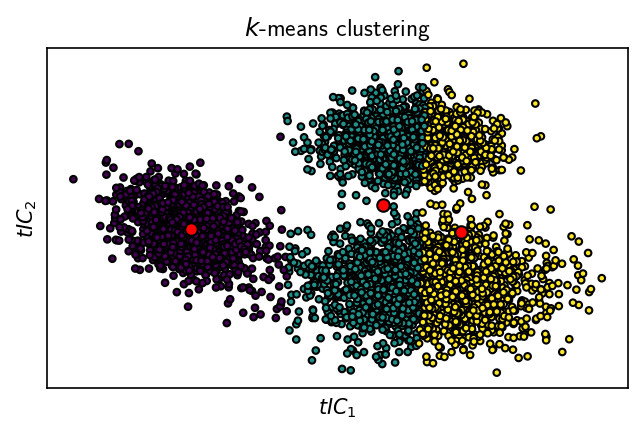

In [61]:
fig, ax = plt.subplots()
ax.scatter(
    *data.T,
    c=system.clustering_voronoi.labels_,
    s=10,
    edgecolors="k", linewidths=1
)

ax.plot(*system.clustering_voronoi.cluster_centers_.T, "o", color="red", markeredgecolor="k")

_ = ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$tIC_1$",
    "ylabel": "$tIC_2$",
    "title": "$k$-means clustering"
})

In [62]:
system.clustering_voronoi = sklearn.cluster.KMeans(n_clusters=100)
system.clustering_voronoi.fit(data)

KMeans(n_clusters=100)

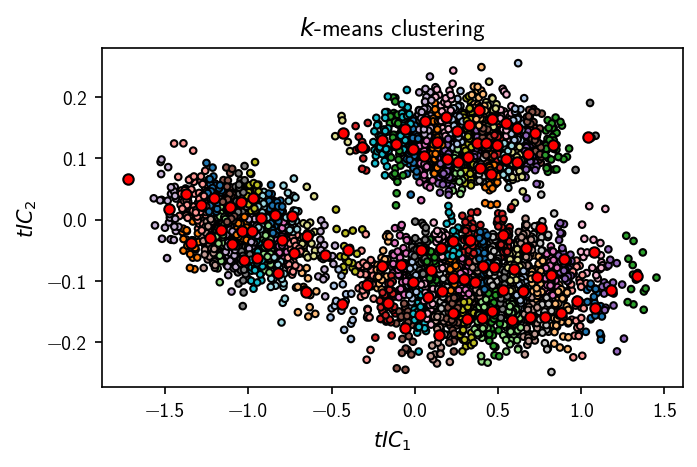

In [63]:
fig, ax = plt.subplots()
ax.scatter(
    *data.T,
    c=system.clustering_voronoi.labels_,
    s=10,
    edgecolors="k", linewidths=1,
    cmap=mpl.cm.tab20
)

ax.plot(
    *system.clustering_voronoi.cluster_centers_.T,
    "o",
    color="red",
    markeredgecolor="k",
    markersize=5
)

_ = ax.set(**{
    # "xticks": (),
    # "yticks": (),
    "xlabel": "$tIC_1$",
    "ylabel": "$tIC_2$",
    "title": "$k$-means clustering"
})

### Exercise

Take your own data set and subject it to a CommonNN and $k$-means clustering.

In [64]:
system = system_a

In [65]:
# Choose the space
data = np.concatenate(system.tica.get_output())

In [66]:
# Prepare for clustering
system.clustering_commonnn = cluster.Clustering(data)

In [67]:
# Cluster with given radius and similarity cutoff
system.clustering_commonnn.fit(0.04, 70, member_cutoff=10)

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
7500      0.040     70        10        None      4         0.532     0.112     00:00:2.085
-----------------------------------------------------------------------------------------------



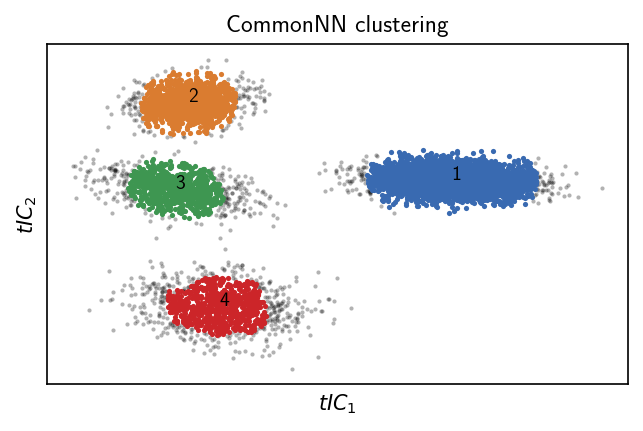

In [68]:
fig, ax = plt.subplots()
system.clustering_commonnn.evaluate(ax=ax)
_ = ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$tIC_1$",
    "ylabel": "$tIC_2$",
    "title": "CommonNN clustering"
})

Alternative Voronoi partitioning:

In [69]:
system.clustering_voronoi = sklearn.cluster.KMeans(n_clusters=4)
system.clustering_voronoi.fit(data)

KMeans(n_clusters=4)

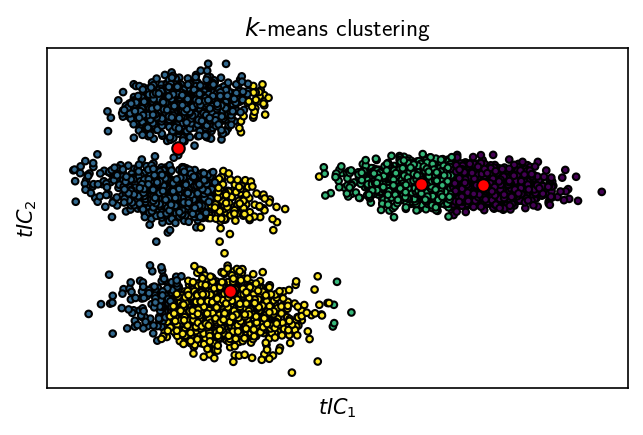

In [70]:
fig, ax = plt.subplots()
ax.scatter(
    *data.T,
    c=system.clustering_voronoi.labels_,
    s=10,
    edgecolors="k", linewidths=1
)

ax.plot(*system.clustering_voronoi.cluster_centers_.T, "o", color="red", markeredgecolor="k")

_ = ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$tIC_1$",
    "ylabel": "$tIC_2$",
    "title": "$k$-means clustering"
})

In [71]:
system.clustering_voronoi = sklearn.cluster.KMeans(n_clusters=100)
system.clustering_voronoi.fit(data)

KMeans(n_clusters=100)

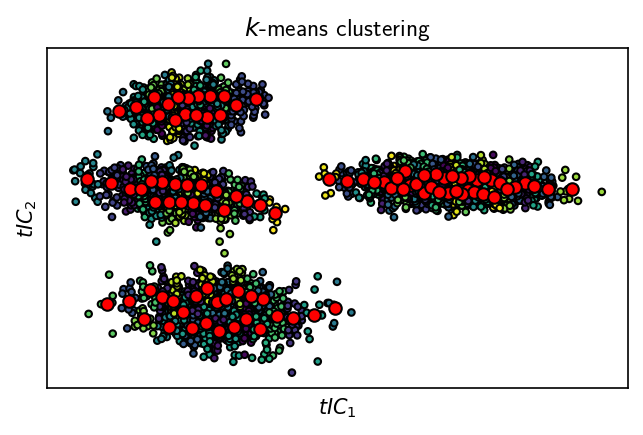

In [72]:
fig, ax = plt.subplots()
ax.scatter(
    *data.T,
    c=system.clustering_voronoi.labels_,
    s=10,
    edgecolors="k", linewidths=1
)

ax.plot(*system.clustering_voronoi.cluster_centers_.T, "o", color="red", markeredgecolor="k")

_ = ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$tIC_1$",
    "ylabel": "$tIC_2$",
    "title": "$k$-means clustering"
})

In [73]:
system = system_a

In [74]:
system.clustering_commonnn = cluster.Clustering(np.concatenate(system.tica.get_output()))

In [75]:
system.clustering_commonnn.fit_hierarchical(0.05, 77, member_cutoff=10)

Running step 0     (r = 0.05, c = 77)


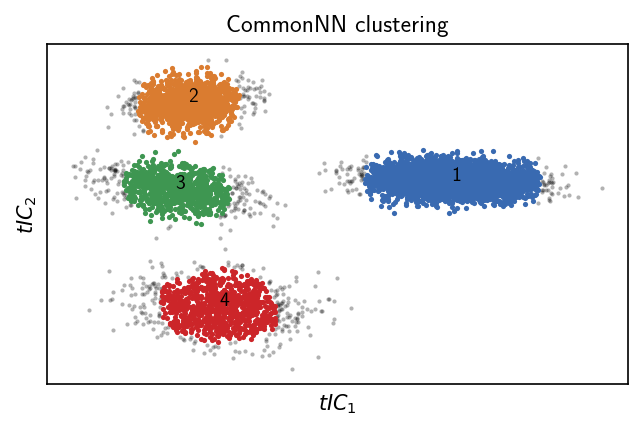

In [76]:
fig, ax = plt.subplots()
system.clustering_commonnn.evaluate(ax=ax)
_ = ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$tIC_1$",
    "ylabel": "$tIC_2$",
    "title": "CommonNN clustering"
})

In [77]:
system.clustering_voronoi = sklearn.cluster.KMeans(n_clusters=100)
system.clustering_voronoi.fit(system.clustering_commonnn.input_data)

KMeans(n_clusters=100)

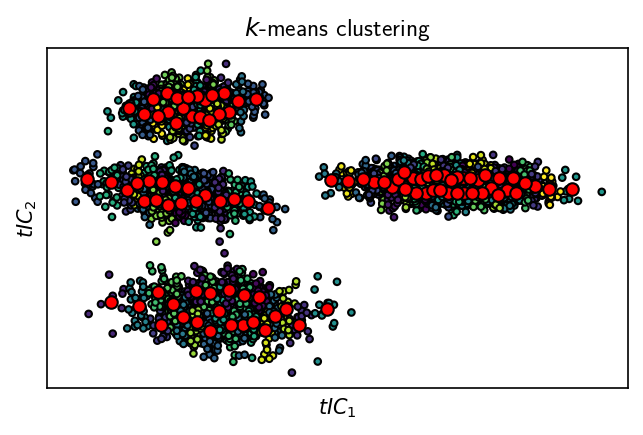

In [78]:
fig, ax = plt.subplots()
ax.scatter(
    *system.clustering_commonnn.input_data.T,
    c=system.clustering_voronoi.labels_,
    s=10,
    edgecolors="k", linewidths=1
)

ax.plot(*system.clustering_voronoi.cluster_centers_.T, "o", color="red", markeredgecolor="k")

_ = ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$tIC_1$",
    "ylabel": "$tIC_2$",
    "title": "$k$-means clustering"
})

## MSM estimation

Finally, we will try to estimate a transition matrix based on the clustering results.

In [79]:
system = system_intro

### CommonNN: core set MSM

In [80]:
# Expose discrete trajectory
dtrajs = [a - 1 for a in system.clustering_commonnn.to_dtrajs()]

In [81]:
dtrajs

[array([2, 2, 2, ..., 1, 1, 1])]

In [82]:
# Compute implied timescales for a few different lag times
its = pyemma.msm.its(dtrajs, lags=[1, 2, 3, 5, 7, 10])

estimating MaximumLikelihoodMSM:   0%|                                                                        …

05-11-21 10:23:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[11] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
05-11-21 10:23:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[11] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
05-11-21 10:23:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[11] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
05-11-21 10:23:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[11] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
05-11-21 10:23:30 pyemma.msm.est

(0.0, 47.63308191708934)

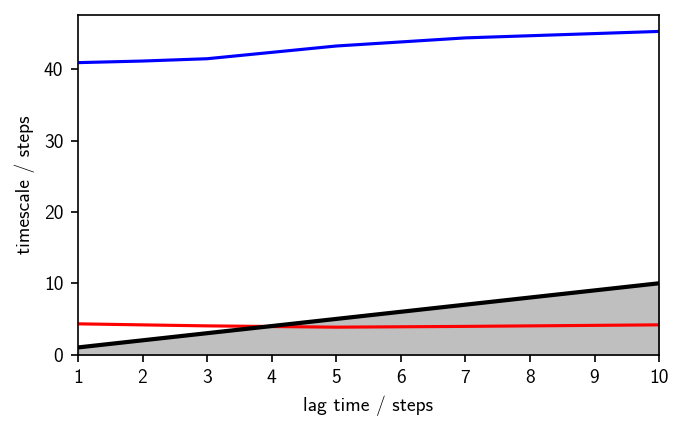

In [83]:
fig, ax = plt.subplots()
pyemma.plots.plot_implied_timescales(its, ylog=False, ax=ax)
ax.set_ylim(0, None)

In [84]:
# Lag time 2 seems to be reasonable
msm = pyemma.msm.estimate_markov_model(dtrajs, lag=2)

05-11-21 10:23:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[11] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.


In [85]:
# Transition probability matrix
msm.P

array([[0.79694093, 0.18086876, 0.02219031],
       [0.18750567, 0.8108851 , 0.00160923],
       [0.03423786, 0.00239502, 0.96336712]])

(<Figure size 750x450 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe963af8100>)

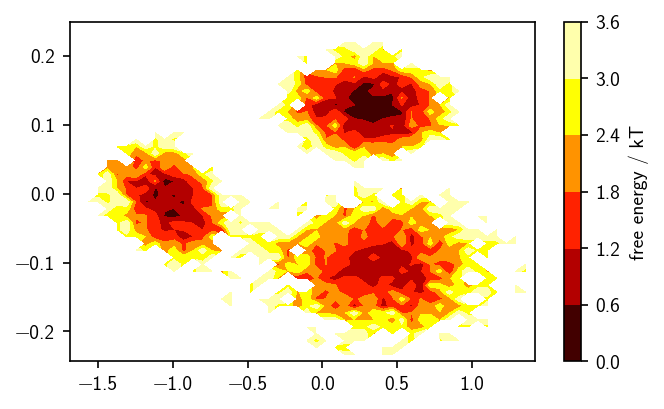

In [86]:
# Reweighted free energy surface
pyemma.plots.plot_free_energy(
    *system.clustering_commonnn.input_data.T,
    weights=np.concatenate(msm.trajectory_weights()),
    ncontours=5, nbins=50, cmap=mpl.cm.hot
)

### *k*-means: conventional MSM

In [87]:
# Expose discrete trajectory
dtrajs = [system.clustering_voronoi.labels_]

In [88]:
dtrajs

[array([59, 74, 49, ..., 87, 87, 28], dtype=int32)]

In [89]:
# Compute implied times scales for a few different lag times
its = pyemma.msm.its(dtrajs, lags=[1, 2, 3, 5, 7, 10], nits=2)

estimating MaximumLikelihoodMSM:   0%|                                                                        …

(0.0, 45.513856645956395)

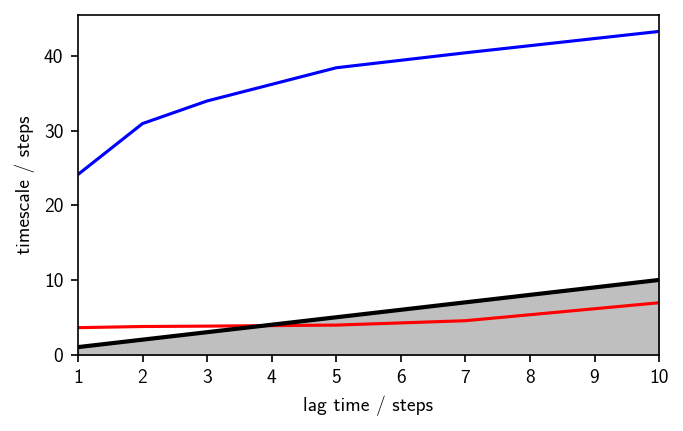

In [90]:
fig, ax = plt.subplots()
pyemma.plots.plot_implied_timescales(its, ylog=False, ax=ax)
ax.set_ylim(0, None)

In [91]:
# Decide for lag time 2
msm = pyemma.msm.estimate_markov_model(dtrajs, lag=2)

In [92]:
# Transition probability matrix
msm.P

array([[5.76923082e-02, 0.00000000e+00, 0.00000000e+00, ...,
        9.64127574e-03, 3.84820411e-02, 0.00000000e+00],
       [0.00000000e+00, 7.59493668e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.58730158e-02, ...,
        7.83133942e-03, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.78090596e-02, 0.00000000e+00, 1.80937721e-02, ...,
        4.44089210e-16, 1.24730049e-01, 0.00000000e+00],
       [2.89700565e-02, 0.00000000e+00, 0.00000000e+00, ...,
        5.08341836e-02, 7.24637688e-02, 7.24271707e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 5.00252532e-01, 4.44089210e-16]])

In [93]:
# 100 states are hard to interpret. Do PCCA to lump microstates into macrostates. 
msm.pcca(3)

PCCA(P=array([[5.76923e-02, 0.00000e+00, ..., 3.84820e-02, 0.00000e+00],
       [0.00000e+00, 7.59494e-02, ..., 0.00000e+00, 0.00000e+00],
       ...,
       [2.89701e-02, 0.00000e+00, ..., 7.24638e-02, 7.24272e-03],
       [0.00000e+00, 0.00000e+00, ..., 5.00253e-01, 4.44089e-16]]),
   m=3)

In [94]:
# Plot macrostates
msm.metastable_assignments

array([0, 2, 1, 2, 0, 1, 1, 2, 2, 2, 0, 0, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2,
       1, 2, 2, 0, 1, 2, 2, 0, 1, 2, 1, 2, 2, 0, 0, 0, 2, 2, 1, 1, 2, 2,
       1, 0, 0, 0, 1, 0, 1, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 1, 2,
       1, 1, 2, 2, 2, 0, 2, 1, 0, 2, 1, 2, 2, 2, 1, 0, 2, 2, 1, 1, 1, 2,
       1, 0, 1, 1, 2, 2, 0, 0, 1, 0, 0, 0])

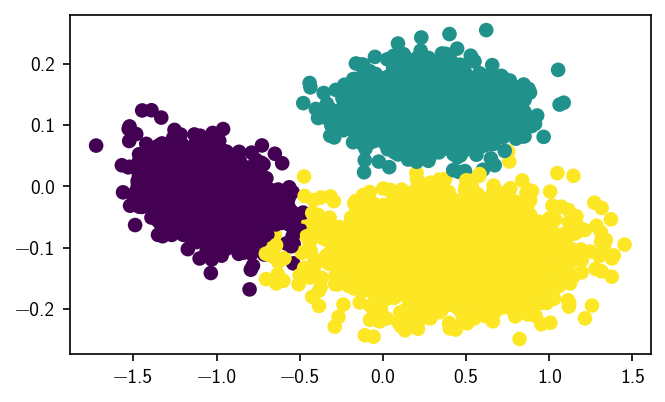

In [95]:
fig, ax = plt.subplots()
ax.scatter(
    *system.clustering_commonnn.input_data.T,
    c=msm.metastable_assignments[dtrajs],
)

### Exercise

Estimate a Markov model for your own data set.

In [96]:
system = system_a

In [97]:
# Expose discrete trajectory
dtrajs = [a - 1 for a in system.clustering_commonnn.to_dtrajs()]

In [98]:
# Compute implied timescales for a few different lag times
its = pyemma.msm.its(dtrajs, lags=[1, 2, 3, 5, 7, 10, 15, 20])

estimating MaximumLikelihoodMSM:   0%|                                                                        …

05-11-21 10:23:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[17] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
05-11-21 10:23:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[17] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
05-11-21 10:23:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[17] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
05-11-21 10:23:30 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[17] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
05-11-21 10:23:30 pyemma.msm.est

(0.0, 21.002304681451154)

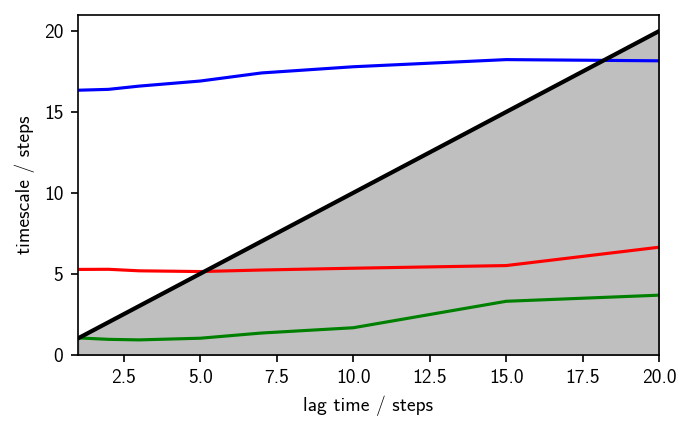

In [99]:
fig, ax = plt.subplots()
pyemma.plots.plot_implied_timescales(its, ylog=False, ax=ax)
ax.set_ylim(0, None)

In [100]:
# Lag time 2 seems to be reasonable
msm = pyemma.msm.estimate_markov_model(dtrajs, lag=3)

05-11-21 10:23:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[17] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.


In [101]:
# Transition probability matrix
msm.P

array([[0.9252064 , 0.02479473, 0.02401185, 0.02598702],
       [0.07413207, 0.71613833, 0.08553199, 0.12419761],
       [0.09873688, 0.11763472, 0.43688363, 0.34674477],
       [0.11064085, 0.17685833, 0.35901722, 0.35348361]])

In [102]:
system.transition_p_matrix

array([[0.97, 0.01, 0.01, 0.01],
       [0.02, 0.89, 0.06, 0.03],
       [0.03, 0.07, 0.6 , 0.3 ],
       [0.04, 0.05, 0.29, 0.62]])

Comparison to conventional MSM.

In [103]:
# Expose discrete trajectory
dtrajs = [system.clustering_voronoi.labels_]

In [104]:
# Compute implied timescales for a few different lag times
its = pyemma.msm.its(dtrajs, lags=[1, 2, 3, 5, 7, 10, 15, 20], nits=3)

estimating MaximumLikelihoodMSM:   0%|                                                                        …

(0.0, 21.004973760884038)

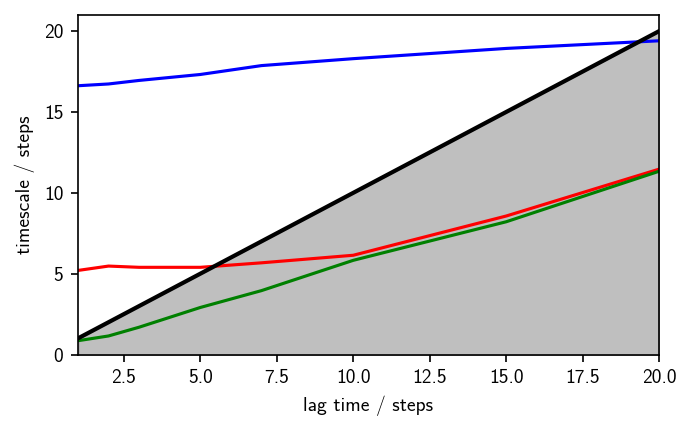

In [105]:
fig, ax = plt.subplots()
pyemma.plots.plot_implied_timescales(its, ylog=False, ax=ax)
ax.set_ylim(0, None)

## Scratch

In [106]:
def multivar_gaussian_pdf(x, cov, mu):
    """Multivariate gaussian PDF"""
    
    n = x.shape[0]
    
    assert n == mu.shape[0] == cov.shape[0] == cov.shape[1], f"! {n} == {mu.shape[0]} == {cov.shape[0]} == {cov.shape[1]}"
    
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    
    delta_xm = x - mu
    
    return 1 / ((2 * np.pi)**(n/2) * np.sqrt(det)) * np.exp(-0.5 * (delta_xm.T @ inv @ delta_xm))